In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
#import tensorflow as tf


import tensorflow
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)
%matplotlib inline 

%reload_ext autoreload
%autoreload 2


!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip /content/annotations_trainval2017.zip
!unzip /content/val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

In [2]:
%cd /content/sample_data
import coco

dataDir='/content/train20171'
dataType='train'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# Initialize the COCO api for instance annotations
coco=coco.COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

/content/sample_data
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': '

In [3]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
print('The class name is', getClassName(77, cats))

The class name is cell phone


Number of images containing all the  classes: 2693


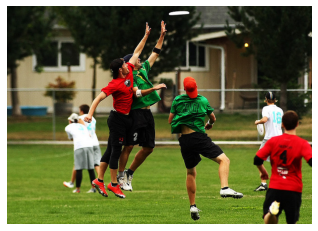

In [6]:
import skimage.io as io
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['person']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/train/{}'.format(dataDir,img['file_name']))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

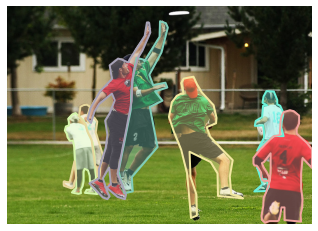

In [7]:
# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [8]:
########## ALl POSSIBLE COMBINATIONS ########
classes = ['person']

images = []
if classes!=None:
    # iterate for each individual class in the list
    for className in classes:
        # get all images containing given class
        catIds = coco.getCatIds(catNms=className)
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(imgIds)
else:
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)
    
# Now, filter out the repeated images    
unique_images = []
for i in range(len(images)):
    if images[i] not in unique_images:
        unique_images.append(images[i])

dataset_size = len(unique_images)

print("Number of images containing the filter classes:", dataset_size)

Number of images containing the filter classes: 2693


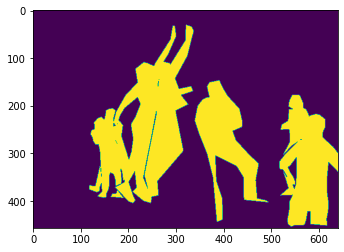

In [9]:
filterClasses = ['person']
mask1 = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask1 = np.maximum(coco.annToMask(anns[i])*pixel_value, mask1)
plt.imshow(mask1)

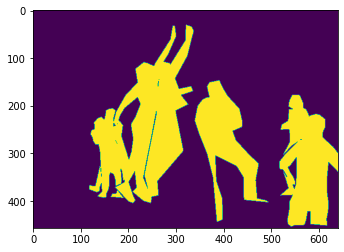

In [10]:
#### GENERATE A BINARY MASK ####
mask2 = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask2 = np.maximum(coco.annToMask(anns[i]), mask2)
plt.imshow(mask2)

In [11]:
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/instances_{}.json'.format(folder, mode)
    #coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [12]:
folder = '/content/train20171'
classes = ['person']
mode = 'train'

images, dataset_size, coco = filterDataset(folder, classes, mode)



In [13]:
import cv2
def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    #print(img_folder + '/' + imageObj['file_name'])
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

In [14]:
countless=0
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'): 
    global countless
    img_folder = '{}/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            countless+=1
            #print('it',countless)
            #print('image',imageObj)
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [38]:
batch_size = 40
input_image_size = (224,224)
mask_type = 'binary'

val_img=[]
train_img=[]
count=1
for i in images:
  if count>2155:
    val_img.append(i)
  else:
    train_img.append(i)
  count+=1
train_gen = dataGeneratorCoco(train_img, classes, coco, folder, 
                            input_image_size, batch_size, mode, mask_type)

In [39]:
img1=[]
mask1=[]
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                ax.imshow(mask[j][:,:,0]);
                
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

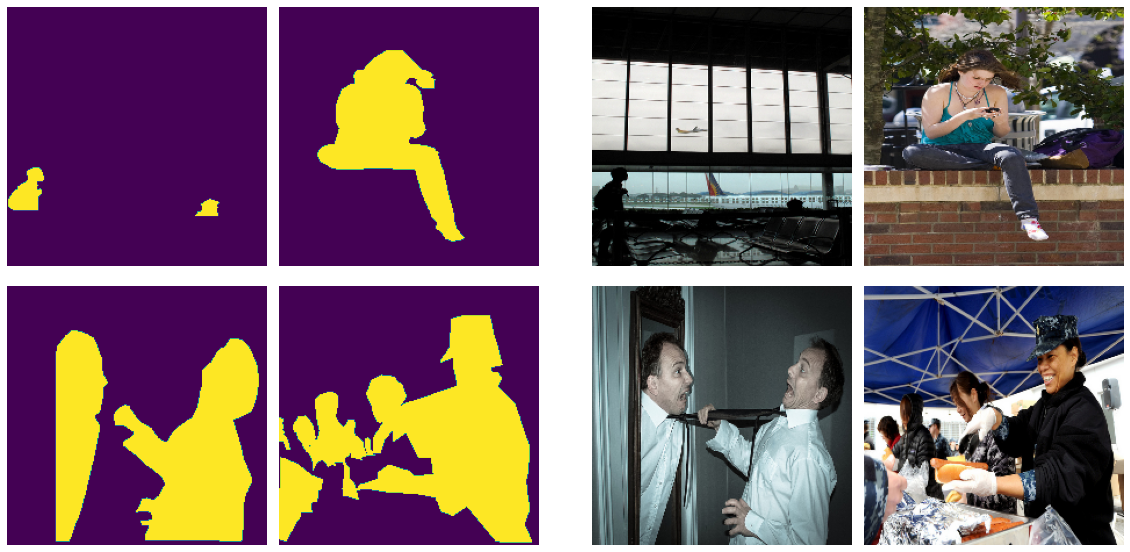

In [17]:
import matplotlib.gridspec as gridspec
visualizeGenerator(train_gen)

In [53]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(224,224,3)),  

    keras.layers.Conv2D(filters=16,kernel_size=3, activation="relu", padding="same", name='layer1_conv1'),
    #keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Conv2D(filters=16,kernel_size=3, activation="relu", padding="same", name='layer1_conv2'),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),

    keras.layers.Conv2D(filters=32,kernel_size=3, activation="relu", padding="same", name='layer2_conv1'),
    #keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Conv2D(filters=32,kernel_size=3, activation="relu", padding="same", name='layer2_conv2'),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),

    keras.layers.Conv2D(filters=64,kernel_size=3, activation="relu", padding="same", name='layer3_conv1'),
    #keras.layers.Dropout(0.3),
    keras.layers.Conv2D(filters=64,kernel_size=3, activation="relu", padding="same", name='layer3_conv2'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),

    keras.layers.Conv2D(filters=128,kernel_size=3, activation="relu", padding="same", name='layer3_conv8'),
    #keras.layers.Dropout(0.3),
    keras.layers.Conv2D(filters=128,kernel_size=3, activation="relu", padding="same", name='layer3_conv9'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),

    keras.layers.UpSampling2D(size=(2, 2)),
    keras.layers.Conv2D(filters=128,kernel_size=3, activation="relu", padding="same", name='layer4_conv9'),
    #keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters=128,kernel_size=3, activation="relu", padding="same", name='layer4_conv8'),

    keras.layers.UpSampling2D(size=(2, 2)),
    keras.layers.Conv2D(filters=64,kernel_size=3, activation="relu", padding="same", name='layer4_conv1'),
    #keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters=64,kernel_size=3, activation="relu", padding="same", name='layer4_conv2'),

    keras.layers.UpSampling2D(size=(2, 2)),
    keras.layers.Conv2D(filters=64,kernel_size=3, activation="relu", padding="same", name='layer4_conv3'),
    #keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters=64,kernel_size=3, activation="relu", padding="same", name='layer4_conv5'),
  
    keras.layers.UpSampling2D(size=(2, 2)),
    keras.layers.Conv2D(filters=32,kernel_size=3, activation="relu", padding="same", name='layer5_conv1'),
    #keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters=16,kernel_size=3, activation="relu", padding="same", name='layer5_conv2'),

    keras.layers.Conv2D(3,(1, 1), activation='sigmoid', padding="same",name='seg')  
  ])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_conv1 (Conv2D)        (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_23 (Batc (None, 224, 224, 16)      64        
_________________________________________________________________
layer1_conv2 (Conv2D)        (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
layer2_conv1 (Conv2D)        (None, 112, 112, 32)      4640      
_________________________________________________________________
batch_normalization_24 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
layer2_conv2 (Conv2D)        (None, 112, 112, 32)     

In [54]:

print(tf.__version__)
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

2.6.0


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [55]:
from IPython.display import clear_output

def display(display_list):
  plt.figure(figsize=(15, 15))
  print('displaying')
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  print('hello')
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = np.expand_dims(pred_mask,axis=-1)
  #pred_mask=pred_mask[0,:,:,:]
  print(pred_mask[0].shape)
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  c=1
  if dataset:
    for img, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([img[0], mask[0], create_mask(pred_mask[tf.newaxis, ...])])
  else:
    img,mask=next(val_gen)
    val=model.predict(img)
    img=img[0,:, :, :]
    mask=mask[0,:, :,:]
    #print(val)
    print(mask.shape)
    print(img.shape)
    display([img, mask,
             create_mask(val)])
  
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
40/40 [==============================] - 26s 636ms/step - loss: 0.6747 - accuracy: 2.0553e-06
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


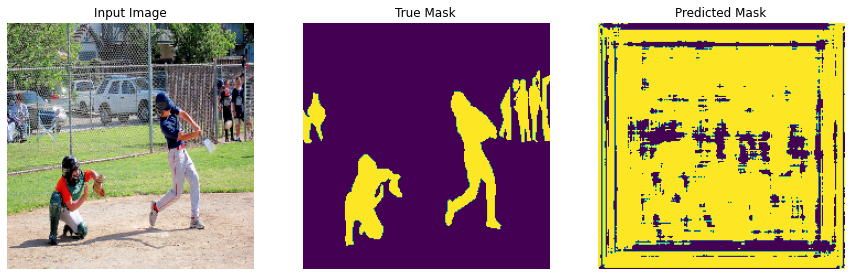


Sample Prediction after epoch 1

Epoch 2/20
40/40 [==============================] - 24s 618ms/step - loss: 0.6227 - accuracy: 1.2456e-06
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


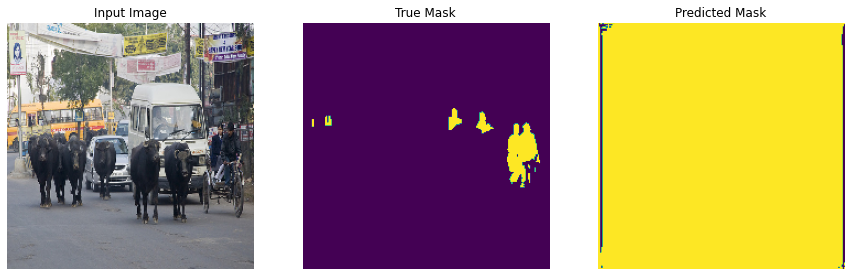


Sample Prediction after epoch 2

Epoch 3/20
40/40 [==============================] - 24s 612ms/step - loss: 0.5379 - accuracy: 1.1372e-05
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


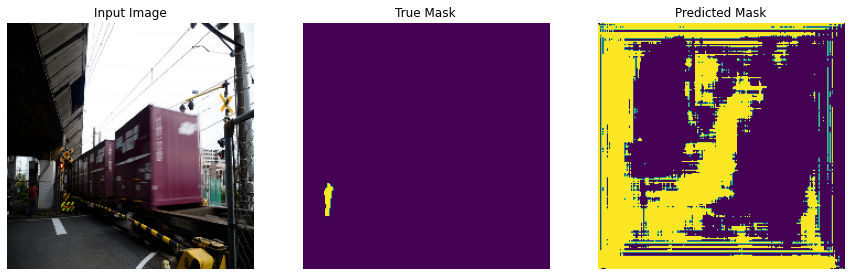


Sample Prediction after epoch 3

Epoch 4/20
40/40 [==============================] - 24s 613ms/step - loss: 0.4533 - accuracy: 0.0242
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


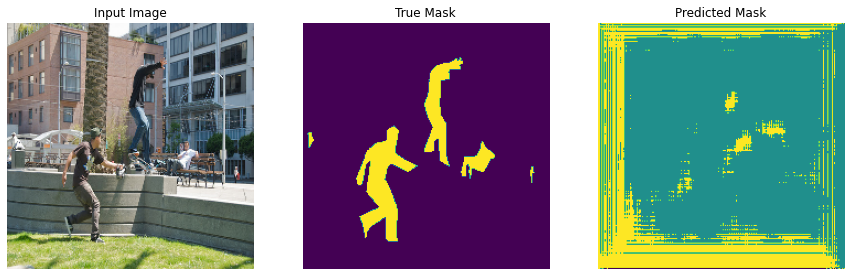


Sample Prediction after epoch 4

Epoch 5/20
40/40 [==============================] - 24s 618ms/step - loss: 0.4084 - accuracy: 0.2288
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


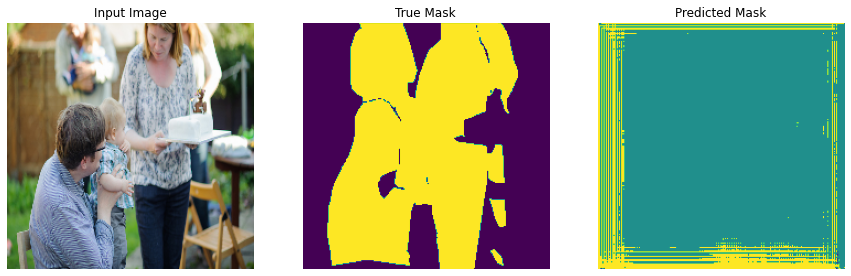


Sample Prediction after epoch 5

Epoch 6/20
40/40 [==============================] - 24s 622ms/step - loss: 0.3977 - accuracy: 0.2843
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


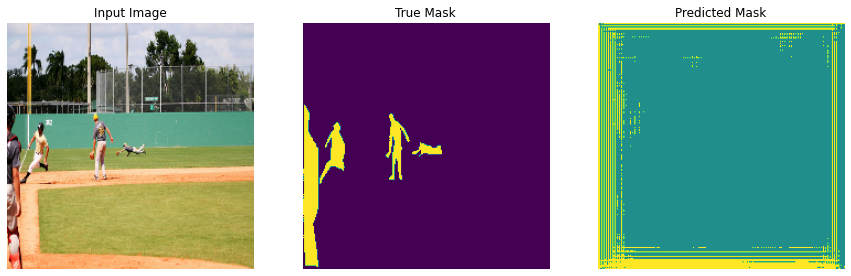


Sample Prediction after epoch 6

Epoch 7/20
40/40 [==============================] - 24s 620ms/step - loss: 0.3843 - accuracy: 0.2594
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


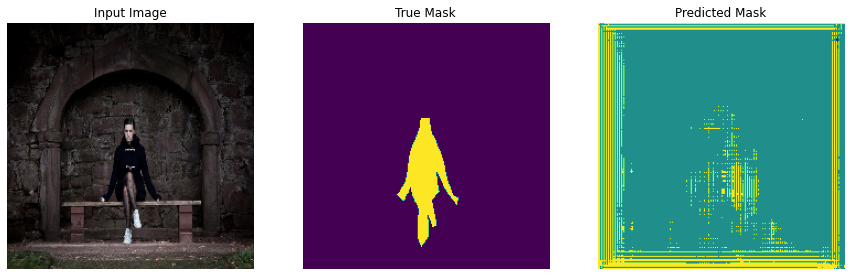


Sample Prediction after epoch 7

Epoch 8/20
40/40 [==============================] - 24s 621ms/step - loss: 0.3799 - accuracy: 0.3676
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


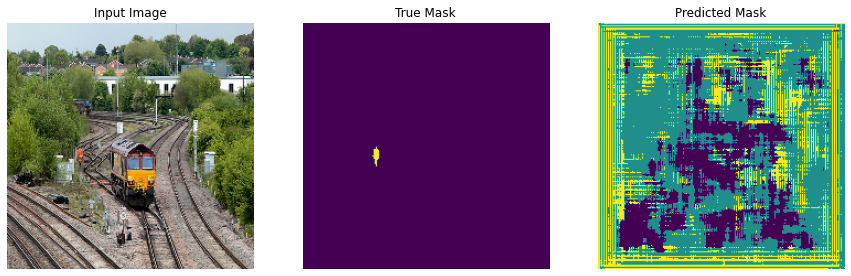


Sample Prediction after epoch 8

Epoch 9/20
40/40 [==============================] - 24s 613ms/step - loss: 0.3718 - accuracy: 0.3734
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


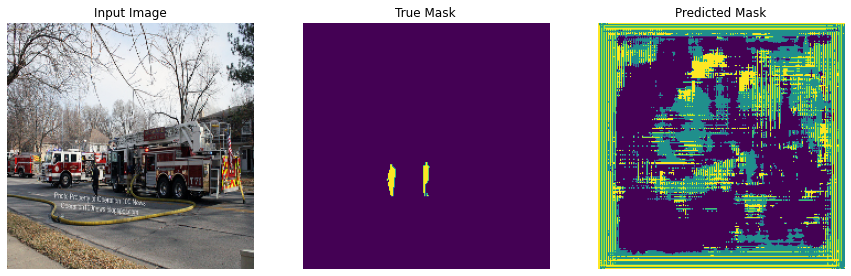


Sample Prediction after epoch 9

Epoch 10/20
40/40 [==============================] - 24s 613ms/step - loss: 0.3751 - accuracy: 0.4099
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


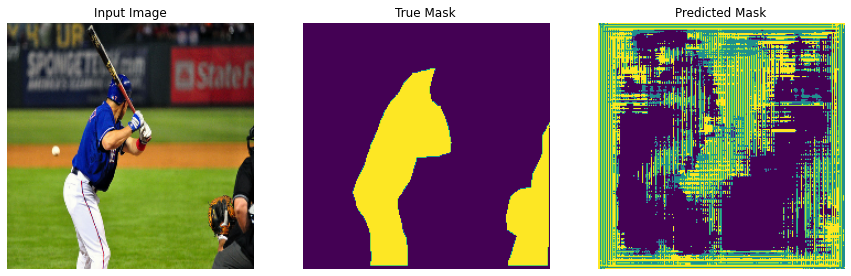


Sample Prediction after epoch 10

Epoch 11/20
40/40 [==============================] - 24s 612ms/step - loss: 0.3672 - accuracy: 0.4890
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


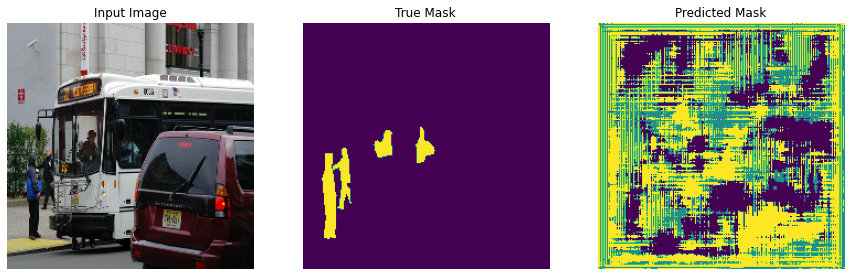


Sample Prediction after epoch 11

Epoch 12/20
40/40 [==============================] - 24s 608ms/step - loss: 0.3738 - accuracy: 0.4129
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


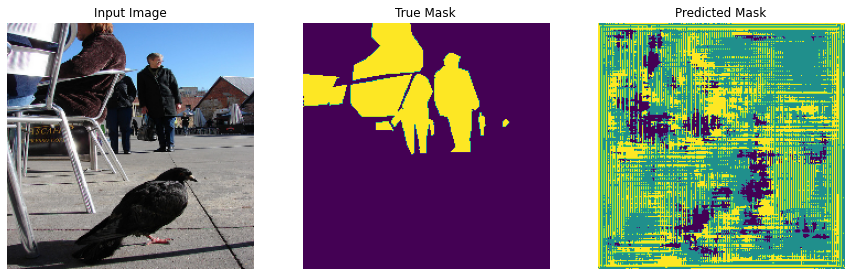


Sample Prediction after epoch 12

Epoch 13/20
40/40 [==============================] - 24s 615ms/step - loss: 0.3578 - accuracy: 0.4310
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


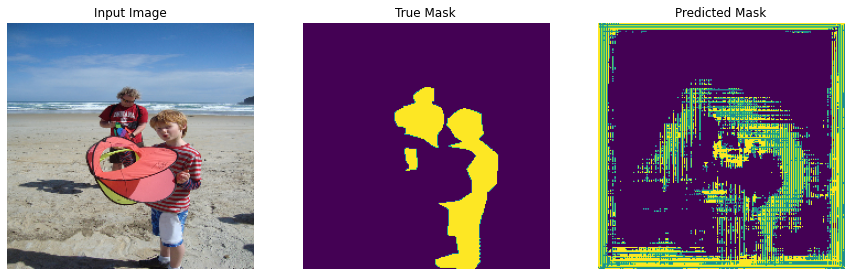


Sample Prediction after epoch 13

Epoch 14/20
40/40 [==============================] - 24s 611ms/step - loss: 0.3641 - accuracy: 0.4756
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


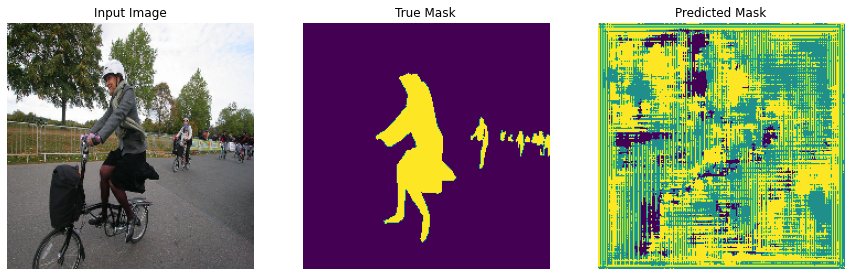


Sample Prediction after epoch 14

Epoch 15/20
40/40 [==============================] - 24s 620ms/step - loss: 0.3561 - accuracy: 0.3823
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


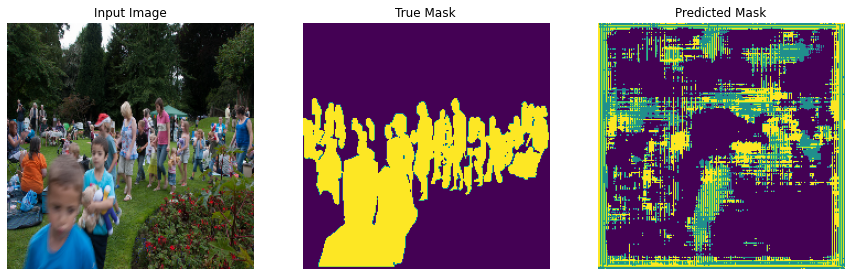


Sample Prediction after epoch 15

Epoch 16/20
40/40 [==============================] - 25s 631ms/step - loss: 0.3564 - accuracy: 0.4734
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


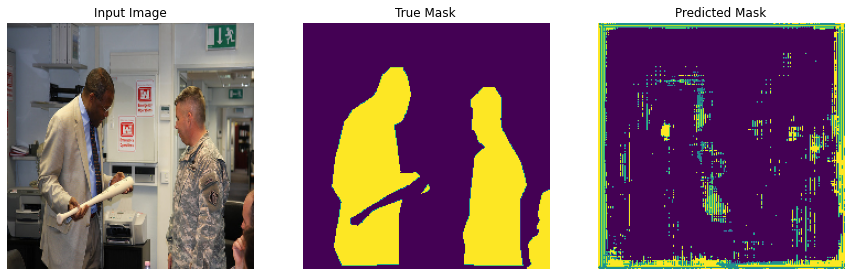


Sample Prediction after epoch 16

Epoch 17/20
40/40 [==============================] - 24s 616ms/step - loss: 0.3594 - accuracy: 0.4075
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


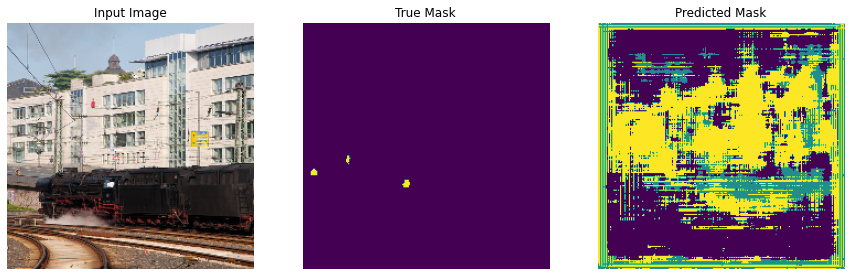


Sample Prediction after epoch 17

Epoch 18/20
40/40 [==============================] - 24s 622ms/step - loss: 0.3475 - accuracy: 0.4234
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


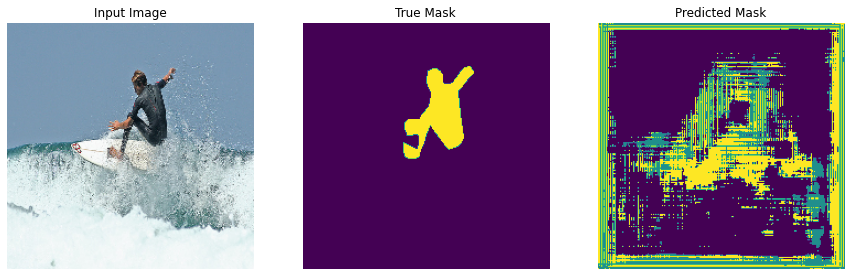


Sample Prediction after epoch 18

Epoch 19/20
40/40 [==============================] - 24s 622ms/step - loss: 0.3471 - accuracy: 0.5121
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


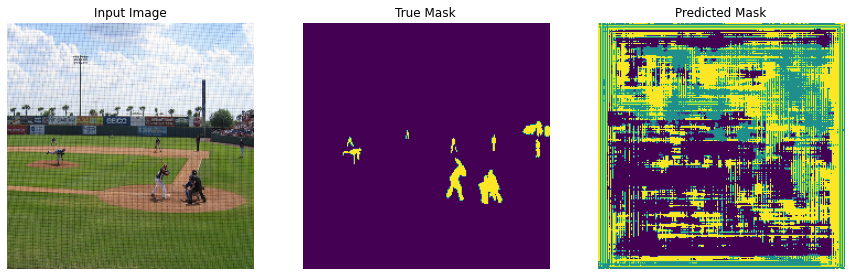


Sample Prediction after epoch 19

Epoch 20/20
40/40 [==============================] - 24s 615ms/step - loss: 0.3472 - accuracy: 0.3873
(224, 224, 1)
(224, 224, 3)
hello
(224, 224, 1)
displaying


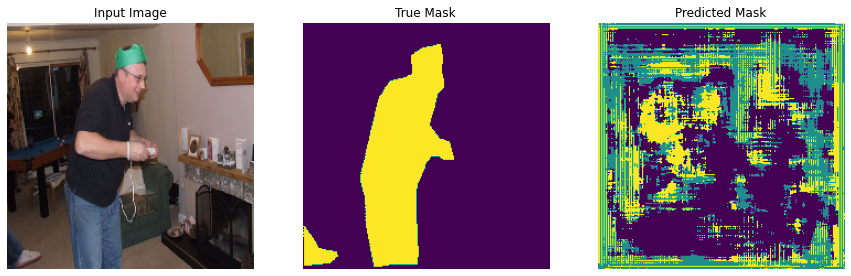


Sample Prediction after epoch 20



In [56]:
# Start the training process
history = model.fit(train_gen,
                steps_per_epoch = 40, 
                epochs = 20, 
                verbose = True,callbacks=[DisplayCallback()])

In [22]:
val_gen = dataGeneratorCoco(val_img, classes, coco, folder, 
                            input_image_size, batch_size, mode, mask_type)
val_preds = model.predict(val_gen,steps=20)
loss,accuracy=model.evaluate(val_gen,steps=20)

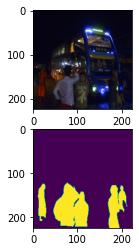

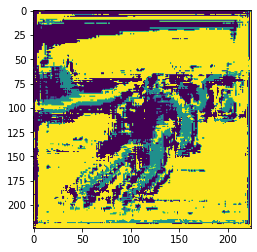

In [64]:
i=3

def predGen(gen,i):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)

    fig, (ax1,ax2) =plt.subplots(2)

    ax1.imshow(img[i]);

    ax2.imshow(mask[i][:,:,0]);
            
    plt.show()

def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = keras.preprocessing.image.array_to_img(mask)
    plt.imshow(img)

predGen(val_gen,i)

# Display mask predicted by our model
display_mask(i)
